# Session 3 - Choropleths
Welcome to this tutorial on creating choropleth maps in Python using Jupyter Notebooks! In this session, we will explore how to visualize geospatial data using color gradients to represent values across a geographic area. Specifically, we will focus on a real-world example of land conservation efforts in Ecuador, showcasing avoided land conversion in various provinces and cantons.

Choropleth maps are a powerful way to communicate spatial patterns and trends. With Python's geospatial libraries such as geopandas, matplotlib, and rasterio, you can easily create stunning and informative maps. In this tutorial, you will learn how to:

1. Load and preprocess geospatial data, including shapefiles and raster files.
2. Merge geospatial and tabular datasets to represent specific metrics.
3. Create custom color maps to highlight important trends.
4. Overlay additional geographic layers (e.g., borders or water bodies) for context.

We will work with Ecuador as our case study, a country with rich biodiversity and ongoing conservation initiatives. By the end of this tutorial, you'll have the skills to create visually appealing and insightful choropleth maps tailored to your own geospatial datasets.

### Setting Up: Libraries for Geospatial Analysis and Visualization

Before diving into creating our choropleth maps, it's essential to set up the necessary Python libraries for geospatial data analysis and visualization. This code chunk loads a variety of powerful tools that will help us handle, process, and visualize geospatial data effectively.

Here’s a quick overview of what each library brings to the table:

- **Core Libraries**:
  - `rasterio` and `georasters`: For working with raster data, such as satellite imagery or land use maps.
  - `geopandas`: A key library for managing vector data like shapefiles (e.g., provinces, cantons).
  - `pandas` and `numpy`: Essential for tabular data processing and numerical computations.

- **Visualization**:
  - `matplotlib`: The go-to library for creating static visualizations, including geospatial plots.
  - `matplotlib.colors` and `ListedColormap`: For creating custom color maps to enhance the readability of our choropleth maps.
  - `matplotlib_scalebar` and `geo_northarrow`: To add map elements like a scale bar and north arrow for context.

- **Spatial Analysis**:
  - `shapely`: For geometric operations, such as creating points, polygons, or boundaries.
  - `rasterstats`: For performing **zonal statistics**, a critical step in calculating land use metrics for geographic regions.

By loading these libraries upfront, we ensure our workflow is streamlined and ready to handle the diverse tasks involved in creating meaningful geospatial visualizations. 

Let’s move forward to preparing the data and creating our first map!

In [4]:
# Load libraries
import rasterio
import numpy as np
import xml.etree.ElementTree as ET
import georasters as gr
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
from pathlib import Path

# For plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
from rasterio.plot import show
from matplotlib.patches import Patch, FancyArrow
from geo_northarrow import add_north_arrow
from pyproj import Transformer
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# For zoning
from rasterstats import zonal_stats

In [161]:
# Get the absolute path of the current notebook
notebook_path = Path(os.path.abspath(''))  # Get the absolute path

# Clear any previous paths or irrelevant directories
os.chdir(notebook_path)
#os.chdir(r'H:\My Drive\AI_survey_projects\geodata_tutorials\01_sessions')

# Verify that the directory is now set correctly
print(f"Current working directory: {os.getcwd()}")

Current working directory: H:\My Drive\AI_survey_projects\geodata_tutorials\01_sessions


### Loading Data: Importing Shapefiles and CSV Files

In this section, we will load the geospatial and tabular data that we need for our analysis and visualization.

1. **Loading Cantons Shapefile**: We begin by loading the shapefile for cantons in Ecuador. The shapefile, `nivel-politico-3.shp`, contains the geographic boundaries of cantons, which are the second-level administrative divisions in Ecuador. This shapefile will be used to map and analyze the regional distribution of land conservation efforts.

2. **Loading Borders Shapefile**: Next, we load another shapefile, `nivel-politico-4.shp`, which contains lower-level political boundaries named parishes. This will provide us with a context for understanding where the cantons are situated within Ecuador.

3. **(Optional) Loading Prediction Data**: Although not actively used in the code provided, there is also a reference to loading a CSV file, `df_final.csv`, which contains prediction data related to land conservation. This file might include results from a model predicting land conversion or conservation, and could be merged later with the geospatial data for visualization.

By loading these datasets, we ensure that we have both the geographical boundaries (cantons and borders) and the prediction data that will allow us to visualize land conservation trends effectively across Ecuador.

In [108]:
cantons = gpd.read_file('../02_data/shapefiles/nivel-politico-3.shp')
borders = gpd.read_file('../02_data/shapefiles/nivel-politico-4.shp')
#df_preds = pd.read_csv('../04_results/model_01/dataframes/df_final.csv')

### Data Preprocessing and Visualization Setup

After loading the geospatial data, we perform some essential data cleaning and preparation to ensure that it aligns with our visualization goals.

1. **Dropping Unnecessary Columns**: The `borders` shapefile contains several columns that are not needed for our analysis. We drop the columns `TERRITORY_`, `CATEGORY`, `TYPE`, and `LEVEL_1` to simplify the data and keep only the relevant attributes. This is done using the `drop` function with the `inplace=True` argument, which modifies the `borders` dataframe directly.

2. **Renaming Columns**: The column names in the `borders` shapefile are not directly aligned with the names we want for our analysis. We rename the columns to make the data more intuitive and consistent with the rest of the project:
   - `NAME` is renamed to `PARROQUIA`, which represents the parish or local administrative region.
   - `LEVEL_2` is renamed to `PROVINCIA`, representing the province.
   - `LEVEL_3` is renamed to `CANTON`, referring to the canton or regional division.

3. **Setting Up a Color Map for Visualization**: To enhance our choropleth map, we create a custom color map (`cmap`) using the `LinearSegmentedColormap` from `matplotlib`. This color map transitions from a yellow-green spectrum, ranging from darker greens to lighter yellows. The range of colors will visually represent the values associated with each region on the map, making it easier to interpret the data.

4. **Normalizing the Color Scale**: The `norm` object is used to normalize the values between 0 and 1, which ensures that the color map is applied consistently across the regions. This step is crucial for creating a visually coherent map where data values are scaled properly within the specified color range.

With the data cleaned and the color map set up, we are now ready to move on to creating meaningful visualizations, like the choropleth map, that can help us better understand the patterns of land conservation in Ecuador.

In [110]:
borders.drop(columns=["TERRITORY_", "CATEGORY", "TYPE", "LEVEL_1"], inplace=True)
borders.rename(columns={"NAME": "PARROQUIA", "LEVEL_2": "PROVINCIA", "LEVEL_3": "CANTON"}, inplace=True)

cmap = mcolors.LinearSegmentedColormap.from_list("yellow_green",
        ["#494f14","#7b8422", "#b7b722", "yellow", "#ffffb2", "#eaffb2",
        "#b2ffb2", "#73d973", "green", "darkgreen"], N=15)
norm = mcolors.Normalize(vmin=0, vmax=1)

### Merging and Preparing Data for Analysis

In this section, we merge data from different years to calculate changes in natural land use over time and prepare it for analysis. The dataset, `df_final`, contains zonal mean values for natural land use for different years. We specifically focus on data from the years 2017, 2022, and 2032.

1. **Loading the Final Data**: The first step is to load the final dataset, `df_final.csv`, which contains information on natural land use across different regions in Ecuador. This dataset includes columns for parish, province, and canton IDs along with zonal mean values for natural land use.

2. **Filtering Data by Year**: We then filter the data for each year of interest:
   - Data for **2017** is extracted and stored in `df_2017`. The `zonal_mean` column is renamed to `zonal_mean_2017` to indicate the values for that year.
   - Data for **2022** is extracted similarly and renamed as `zonal_mean_2022`.
   - Data for **2032** is extracted and renamed as `zonal_mean_2032`.

3. **Merging Data**: Once we have the data for each year in separate dataframes, we merge them into a single dataframe (`df_merged`) using the common columns: `parish_id`, `PARROQUIA`, `PROVINCIA`, and `CANTON`. This ensures that the zonal mean values for each year are aligned correctly by geographic area. We use a **left join** to keep all records from the 2017 dataset and add the corresponding data for 2022 and 2032 where available.

By merging the data from these three years, we set up the foundation for calculating changes in land use and visualizing the trends over time across different regions. This merged dataset will be crucial for understanding how land use is evolving in Ecuador.

In [5]:
### THESE MERGE (AND IN OTHER SCRIPTS) SHOULD BE DONE BY UBIGEO COLUMN THAT ITS ADDED WITH RMD
# Load the final dataframe
df_final = pd.read_csv("../02_data/database/df_final.csv")

# We will calculate the change in natural land use variables between 2017 and 2022 and between 2022 and 2032
df_2017 = df_final[df_final['year'] == 2017][['parish_id', 'zonal_mean', 'PARROQUIA', 'PROVINCIA', 'CANTON']]
df_2017.rename(columns={'zonal_mean': 'zonal_mean_2017'}, inplace=True)

df_2022 = df_final[df_final['year'] == 2022][['parish_id', 'zonal_mean', 'PARROQUIA','PROVINCIA', 'CANTON']]
df_2022.rename(columns={'zonal_mean': 'zonal_mean_2022'}, inplace=True)

df_2032 = df_final[df_final['year'] == 2032][['parish_id', 'zonal_mean', 'PARROQUIA','PROVINCIA', 'CANTON']]
df_2032.rename(columns={'zonal_mean': 'zonal_mean_2032'}, inplace=True)

df_merged = df_2017.merge(df_2022, on=['parish_id', 'PARROQUIA', 'PROVINCIA', 'CANTON'], how='left')
df_merged = df_merged.merge(df_2032, on=['parish_id', 'PARROQUIA', 'PROVINCIA', 'CANTON'], how='left')

### Calculating the Avoided Conversion Variable

In this section, we calculate a new variable, **avoided conversion**, which measures the change in natural land use between 2022 and 2032. This variable is key for understanding areas where land conversion (e.g., from natural land to urban or agricultural use) may be avoided in future projections.

1. **Calculating the Difference in Zonal Mean**: We begin by calculating the absolute difference between the zonal mean values for 2032 and 2022. This difference represents the change in natural land use between the two years. We compute the minimum and maximum values of this difference across all regions to help normalize the avoided conversion values later.

2. **Avoided Conversion Calculation**: The **avoided conversion** variable is calculated for each region in the dataset. The logic is as follows:
   - If the zonal mean value for 2032 is greater than or equal to 2022, no conversion is considered to be avoided, so the value is set to 0.
   - If the zonal mean value for 2032 is less than that for 2022, it indicates a potential avoided conversion (i.e., a reduction in land conversion). The absolute difference is then normalized between the minimum and maximum differences calculated earlier. This ensures that the values fall between 0 and 1, with larger values representing areas where more land conversion is avoided.

3. **Applying the Calculation**: The avoided conversion variable is applied across the entire dataset using the `apply` function, which operates row by row. This allows for individual calculations for each region based on its specific values for 2022 and 2032.

4. **Previewing the Results**: Finally, we print a preview of the first few rows of the dataset, showing the zonal mean values for 2032 and 2022, as well as the newly calculated avoided conversion values. This preview helps us quickly check the results and ensure that the calculation was performed correctly.

This newly created variable will be useful for further analysis and visualization, as it quantifies the potential for land conservation or avoidance of land conversion across different regions in Ecuador.

In [8]:
# Compute avoided conversion variable
# Ensure no division by zero during normalization
min_diff = df_merged['zonal_mean_2032'].sub(df_merged['zonal_mean_2022']).abs().min()
max_diff = df_merged['zonal_mean_2032'].sub(df_merged['zonal_mean_2022']).abs().max()

# Compute avoided_conversion
df_merged['avoided_conversion'] = df_merged.apply(
    lambda row: 0 if (row['zonal_mean_2032'] - row['zonal_mean_2022']) >= 0 
    else (abs(row['zonal_mean_2032'] - row['zonal_mean_2022']) - min_diff) / (max_diff - min_diff) if max_diff > min_diff else 0,
    axis=1
)

# Preview results
print(df_merged[['zonal_mean_2032', 'zonal_mean_2022', 'avoided_conversion']].head())

   zonal_mean_2032  zonal_mean_2022  avoided_conversion
0         0.178204         0.208280            0.208918
1         0.605459         0.626034            0.142917
2         0.323140         0.348804            0.178264
3         0.605598         0.622152            0.114987
4         0.475528         0.451763            0.000000


In [16]:
df_merged['avoided_conversion'].max()

1.0

count    1031.000000
mean        0.054011
std         0.078831
min         0.000000
25%         0.000000
50%         0.021481
75%         0.082737
max         1.000000
Name: avoided_conversion, dtype: float64


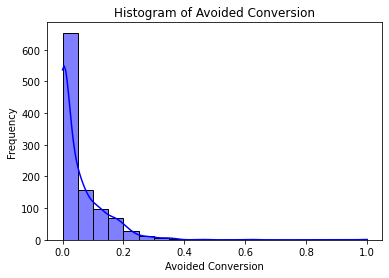

In [135]:
# Summary of avoided_conversion
print(df_merged['avoided_conversion'].describe())

# Histogram of avoided_conversion
sns.histplot(df_merged['avoided_conversion'], bins=20, kde=True, color='blue')
plt.title('Histogram of Avoided Conversion')
plt.xlabel('Avoided Conversion')
plt.ylabel('Frequency')
plt.show()

### Very similar for restoration variable

In [122]:
# Compute restoration variable
# Ensure no division by zero during normalization
min_diff = df_merged['zonal_mean_2022'].sub(df_merged['zonal_mean_2017']).abs().min()
max_diff = df_merged['zonal_mean_2022'].sub(df_merged['zonal_mean_2017']).abs().max()

# Compute avoided_conversion
df_merged['restoration'] = df_merged.apply(
    lambda row: 0 if (row['zonal_mean_2022'] - row['zonal_mean_2017']) >= 0 
    else (abs(row['zonal_mean_2022'] - row['zonal_mean_2017']) - min_diff) / (max_diff - min_diff) if max_diff > min_diff else 0,
    axis=1
)

# Preview results
print(df_merged[['zonal_mean_2022', 'zonal_mean_2017', 'restoration']].head())

   zonal_mean_2022  zonal_mean_2017  restoration
0         0.208280         0.245040     0.158510
1         0.626034         0.677980     0.223993
2         0.348804         0.370810     0.094892
3         0.622152         0.631126     0.038697
4         0.451763         0.434316     0.000000


count    1031.000000
mean        0.084940
std         0.130895
min         0.000000
25%         0.000000
50%         0.022128
75%         0.129218
max         1.000000
Name: restoration, dtype: float64


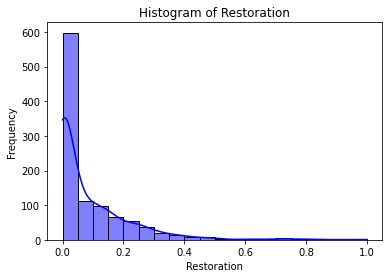

In [136]:
# Summary of avoided_conversion
print(df_merged['restoration'].describe())

# Histogram of avoided_conversion
sns.histplot(df_merged['restoration'], bins=20, kde=True, color='blue')
plt.title('Histogram of Restoration')
plt.xlabel('Restoration')
plt.ylabel('Frequency')
plt.show()

### Plotting the Avoided Conversion Variable on Ecuador's Map

In this section, we visualize the **avoided conversion** variable calculated earlier by plotting it on a map of Ecuador. The process involves several steps to prepare and customize the map for effective presentation.

1. **Merging Data with Borders**: We begin by merging the land use data with the borders shapefile using common identifiers like `PARROQUIA`, `PROVINCIA`, and `CANTON`. This allows us to associate land use data with the corresponding geographic regions. We also convert the resulting dataframe into a GeoDataFrame to handle geographic information properly.

2. **Setting Color Map**: To visualize the avoided conversion values, we define a custom color map (`red_white_green`) using a range from red to green. This color map will represent the intensity of avoided conversion, with red indicating low values and green indicating higher values. We also set the color scale to range between 0 and 1.

3. **Loading and Preparing the Raster Data**: The next step involves loading raster data (e.g., satellite imagery or land cover data) for Ecuador. The raster data is read using `rasterio`, and a specific portion of the data is sliced for the area of interest. We also define a coordinate reference system (CRS) that matches the map's projections for accurate alignment.

4. **Plotting Borders**: To provide context for the data, we load the borders of Ecuador and its surrounding oceans. The ocean borders are plotted first to ensure they appear beneath the land areas, and the Ecuadorian national borders are plotted afterward. These elements help frame the map and provide geographic context.

5. **Plotting Avoided Conversion Data**: With the geographic context in place, we then plot the **avoided conversion** data on top. The data is displayed using the custom color map, and regions are outlined with black borders to distinguish them clearly. A color bar is added to the map to represent the scale of the avoided conversion values.

6. **Adding Additional Map Elements**: For further clarity, the map includes:
   - **Country Labels**: Text labels are added for neighboring countries (e.g., Peru and Colombia) and the Pacific Ocean.
   - **Scalebar**: A scalebar is added to the map to indicate distances in kilometers, providing a sense of scale.
   - **North Arrow**: A north arrow is placed on the map to show the orientation.
   - **Title and Annotations**: A title is added to the map, along with a timestamp indicating the years of analysis (2022 to 2032).

7. **Customization**: Finally, axis ticks and labels are removed to create a cleaner map, and the title is customized to reflect the nature of the analysis (avoided conversion). The map is ready for export or presentation.

This map visually represents the spatial distribution of avoided land conversion across Ecuador, offering insights into areas that are expected to see the most significant land use changes between 2022 and 2032.

In [144]:
# Merge the data with the borders shapefile
gdf_final = df_merged.merge(borders, on=['PARROQUIA', 'PROVINCIA', 'CANTON'], how='left')
gdf_final = gpd.GeoDataFrame(gdf_final, geometry='geometry')

# Set the range for the color scale
vmin, vmax = 0, 1 

# Set colorramp 
red_white_green = mcolors.LinearSegmentedColormap.from_list("RedGreen", 
                                                            ["red", "white", "#00cc00"])

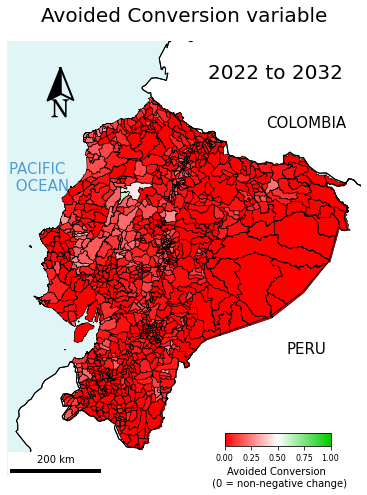

In [151]:
with rasterio.open(f'../02_data/MB-Ecuador-2022.tif') as src:
    data = src.read(1)
    sliced_data = data[:, 40000:]
    new_transform = src.window_transform(((0, data.shape[0]), (40000, data.shape[1])))
    raster_crs = src.crs

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    ecuador_borders = gpd.read_file('../02_data/shapefiles/ecuador_borders.shp')
    ocean_borders = gpd.read_file('../02_data/shapefiles/ne_10m_ocean.shp')

    # Set CRS if needed and reproject to raster CRS as before
    ecuador_borders = ecuador_borders.set_crs("EPSG:4326") if ecuador_borders.crs is None else ecuador_borders
    ecuador_borders = ecuador_borders.to_crs(raster_crs)
    ocean_borders = ocean_borders.set_crs("EPSG:4326") if ocean_borders.crs is None else ocean_borders
    ocean_borders = ocean_borders.to_crs(raster_crs)

    # Plot ocean borders first to be behind the parishes
    ocean_borders.plot(ax=ax, color='#b2e8e8', alpha=0.4, linewidth=0.5)

    # Then plot the Ecuador borders
    ecuador_borders.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    ecuador_borders.plot(ax=ax, color='#ffffff', edgecolor='black', linewidth=1)

    # Plot the geodataframe
    gdf_final.plot(column='avoided_conversion', 
                cmap=red_white_green,  # custom colormap :)
                legend=False, 
                edgecolor='black',
                linewidth=0.6,
                vmin=vmin, vmax=vmax,
                ax=ax)

    cax = inset_axes(ax, width="30%", height="3%", loc="lower right", borderpad=3)
    sm = plt.cm.ScalarMappable(cmap=red_white_green, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
    cbar.set_label('Avoided Conversion \n (0 = non-negative change)', fontsize=10, color='black')
    cbar.ax.tick_params(labelsize=8)
    #cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)} pp'))

    ax.text(-76, -3.15, 'PERU', fontsize=15, color='black', ha='center', va='center')
    ax.text(-76, 1, 'COLOMBIA', fontsize=15, color='black', ha='center', va='center')
    ax.text(-80.9, 0, 'PACIFIC \n OCEAN', fontsize=15, color='#519ad0', ha='center', va='center')

    transformer = Transformer.from_crs("EPSG:4326", raster_crs)
    xmin, ymin = transformer.transform(-81.5, -5.5)
    xmax, ymax = transformer.transform(-75, 2.5)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    scalebar = ScaleBar(120, units='km', location='lower left', scale_loc='top', length_fraction=6667 / sliced_data.shape[1])
    ax.add_artist(scalebar)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    add_north_arrow(ax, scale=.75, xlim_pos=.15, ylim_pos=.865, color='#000', text_scaler=4, text_yT=-1.25)

    # Set title and remove axis for a cleaner map look
    ax.set_title('Avoided Conversion variable', color='black', size=20, pad=20.0)
    ax.text(0.95, 0.95, '2022 to 2032', transform=ax.transAxes, fontsize=20, color='black', ha='right', va='top')
    ax.set_axis_off()

    #plt.savefig(f'../04_results/{model}/land_use_change/ecuador_land_use_change_1985_2022.png', dpi=600, bbox_inches='tight')
    #print(f"The plot have been saved as '../04_results/{model}/land_use_change/ecuador_land_use_change_1985_2022.png'.")

### The same for restoration variable

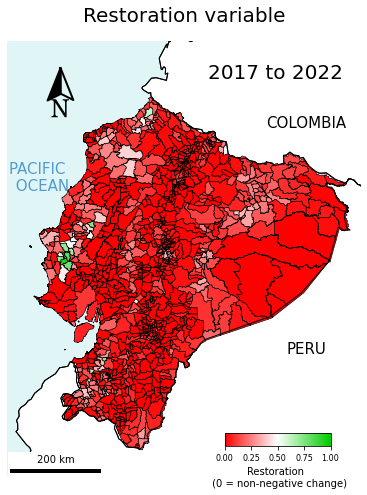

In [153]:
with rasterio.open(f'../02_data/MB-Ecuador-2022.tif') as src:
    data = src.read(1)
    sliced_data = data[:, 40000:]
    new_transform = src.window_transform(((0, data.shape[0]), (40000, data.shape[1])))
    raster_crs = src.crs

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    ecuador_borders = gpd.read_file('../02_data/shapefiles/ecuador_borders.shp')
    ocean_borders = gpd.read_file('../02_data/shapefiles/ne_10m_ocean.shp')

    # Set CRS if needed and reproject to raster CRS as before
    ecuador_borders = ecuador_borders.set_crs("EPSG:4326") if ecuador_borders.crs is None else ecuador_borders
    ecuador_borders = ecuador_borders.to_crs(raster_crs)
    ocean_borders = ocean_borders.set_crs("EPSG:4326") if ocean_borders.crs is None else ocean_borders
    ocean_borders = ocean_borders.to_crs(raster_crs)

    # Plot ocean borders first to be behind the parishes
    ocean_borders.plot(ax=ax, color='#b2e8e8', alpha=0.4, linewidth=0.5)

    # Then plot the Ecuador borders
    ecuador_borders.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    ecuador_borders.plot(ax=ax, color='#ffffff', edgecolor='black', linewidth=1)

    # Plot the geodataframe
    gdf_final.plot(column='restoration', 
                cmap=red_white_green,  # custom colormap :)
                legend=False, 
                edgecolor='black',
                linewidth=0.6,
                vmin=vmin, vmax=vmax,
                ax=ax)

    cax = inset_axes(ax, width="30%", height="3%", loc="lower right", borderpad=3)
    sm = plt.cm.ScalarMappable(cmap=red_white_green, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
    cbar.set_label('Restoration \n (0 = non-negative change)', fontsize=10, color='black')
    cbar.ax.tick_params(labelsize=8)
    #cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)} pp'))

    ax.text(-76, -3.15, 'PERU', fontsize=15, color='black', ha='center', va='center')
    ax.text(-76, 1, 'COLOMBIA', fontsize=15, color='black', ha='center', va='center')
    ax.text(-80.9, 0, 'PACIFIC \n OCEAN', fontsize=15, color='#519ad0', ha='center', va='center')

    transformer = Transformer.from_crs("EPSG:4326", raster_crs)
    xmin, ymin = transformer.transform(-81.5, -5.5)
    xmax, ymax = transformer.transform(-75, 2.5)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    scalebar = ScaleBar(120, units='km', location='lower left', scale_loc='top', length_fraction=6667 / sliced_data.shape[1])
    ax.add_artist(scalebar)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    add_north_arrow(ax, scale=.75, xlim_pos=.15, ylim_pos=.865, color='#000', text_scaler=4, text_yT=-1.25)

    # Set title and remove axis for a cleaner map look
    ax.set_title('Restoration variable', color='black', size=20, pad=20.0)
    ax.text(0.95, 0.95, '2017 to 2022', transform=ax.transAxes, fontsize=20, color='black', ha='right', va='top')
    ax.set_axis_off()

    #plt.savefig(f'../04_results/{model}/land_use_change/ecuador_land_use_change_1985_2022.png', dpi=600, bbox_inches='tight')

    #print(f"The plot have been saved as '../04_results/{model}/land_use_change/ecuador_land_use_change_1985_2022.png'.")

### Plotting Avoided Conversion with Canton Boundaries Overlayed

This plot builds on the previous visualization of the **avoided conversion** variable but introduces one key difference: the **canton boundaries** are overlaid with a hollow (transparent) fill and black outlines. This allows the parish-level colors representing avoided conversion to remain clearly visible in the background while adding an additional layer of administrative context.

All other steps, including merging data, setting the color map, adding contextual layers (ocean and Ecuador borders), and customizing the map with a scalebar, north arrow, and annotations, follow the same process as in the previous plot.

This addition of canton boundaries provides a clearer geographic reference for viewers, helping to situate the parishes within their respective cantons without overshadowing the detailed parish-level data.

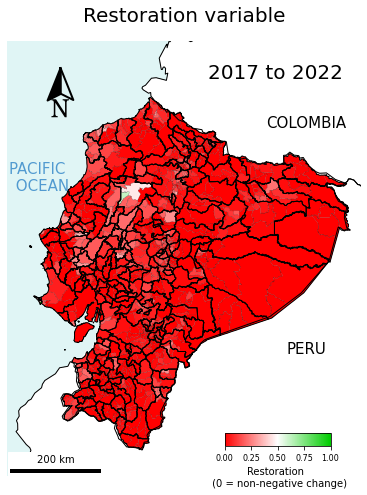

In [155]:
with rasterio.open(f'../02_data/MB-Ecuador-2022.tif') as src:
    data = src.read(1)
    sliced_data = data[:, 40000:]
    new_transform = src.window_transform(((0, data.shape[0]), (40000, data.shape[1])))
    raster_crs = src.crs

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    ecuador_borders = gpd.read_file('../02_data/shapefiles/ecuador_borders.shp')
    ocean_borders = gpd.read_file('../02_data/shapefiles/ne_10m_ocean.shp')

    # Set CRS if needed and reproject to raster CRS as before
    ecuador_borders = ecuador_borders.set_crs("EPSG:4326") if ecuador_borders.crs is None else ecuador_borders
    ecuador_borders = ecuador_borders.to_crs(raster_crs)
    ocean_borders = ocean_borders.set_crs("EPSG:4326") if ocean_borders.crs is None else ocean_borders
    ocean_borders = ocean_borders.to_crs(raster_crs)
    cantons = cantons.set_crs("EPSG:4326") if cantons.crs is None else cantons
    cantons = cantons.to_crs(raster_crs)

    # Plot ocean borders first to be behind the parishes
    ocean_borders.plot(ax=ax, color='#b2e8e8', alpha=0.4, linewidth=0.5)

    # Then plot the Ecuador borders
    ecuador_borders.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    ecuador_borders.plot(ax=ax, color='#ffffff', edgecolor='black', linewidth=0.1)

    # Plot the geodataframe
    gdf_final.plot(column='avoided_conversion', 
                cmap=red_white_green,  # custom colormap :)
                legend=False, 
                edgecolor='black',
                linewidth=0.1,
                vmin=vmin, vmax=vmax,
                ax=ax)

    # Plot cantones
    cantons = gpd.GeoDataFrame(cantons, geometry='geometry')
    cantons.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

    cax = inset_axes(ax, width="30%", height="3%", loc="lower right", borderpad=3)
    sm = plt.cm.ScalarMappable(cmap=red_white_green, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
    cbar.set_label('Restoration \n (0 = non-negative change)', fontsize=10, color='black')
    cbar.ax.tick_params(labelsize=8)
    #cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)} pp'))

    ax.text(-76, -3.15, 'PERU', fontsize=15, color='black', ha='center', va='center')
    ax.text(-76, 1, 'COLOMBIA', fontsize=15, color='black', ha='center', va='center')
    ax.text(-80.9, 0, 'PACIFIC \n OCEAN', fontsize=15, color='#519ad0', ha='center', va='center')

    transformer = Transformer.from_crs("EPSG:4326", raster_crs)
    xmin, ymin = transformer.transform(-81.5, -5.5)
    xmax, ymax = transformer.transform(-75, 2.5)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    scalebar = ScaleBar(120, units='km', location='lower left', scale_loc='top', length_fraction=6667 / sliced_data.shape[1])
    ax.add_artist(scalebar)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    add_north_arrow(ax, scale=.75, xlim_pos=.15, ylim_pos=.865, color='#000', text_scaler=4, text_yT=-1.25)

    # Set title and remove axis for a cleaner map look
    ax.set_title('Restoration variable', color='black', size=20, pad=20.0)
    ax.text(0.95, 0.95, '2017 to 2022', transform=ax.transAxes, fontsize=20, color='black', ha='right', va='top')
    ax.set_axis_off()

    #plt.savefig(f'../04_results/{model}/land_use_change/ecuador_land_use_change_1985_2022.png', dpi=600, bbox_inches='tight')

    #print(f"The plot have been saved as '../04_results/{model}/land_use_change/ecuador_land_use_change_1985_2022.png'.")